In [1]:
import cv2
import numpy as np
import os
import sys
import dlib
import pandas as pd
from matplotlib import pyplot as plt

In [10]:
SHORT_TEST = False
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

In [13]:
def get_rect(shape):
    rw = 0
    rh = 0
    rx = 65535
    ry = 65535
    for (x,y) in shape:
        rw = max(rw,x)
        rh = max(rh,y)
        rx = min(rx,x)
        ry = min(ry,y)
    return (rx,ry,rw-rx,rh-ry)
def shape_to_np(shape, dtype="int"):
    # initialize the list of (x, y)-coordinates
    coords = np.zeros((shape.num_parts, 2), dtype=dtype)

    # loop over all facial landmarks and convert them
    # to a 2-tuple of (x, y)-coordinates
    for i in range(0, shape.num_parts):
        coords[i] = (shape.part(i).x, shape.part(i).y)

    # return the list of (x, y)-coordinates
    return coords

In [14]:
inpDir = 'dataset\dataset'
person = {}
img = None
mouth = None
firstImg = None
firstPerson = None
firstSentenceId = None
firstSentenceId2 = None
ratio = 1.0/2.0
pi = 0
linpDir = os.listdir(inpDir)
for personStr in linpDir:
    pi += 1
    print("person: %s [%d/%d]" % (personStr,pi,len(linpDir)))
    person[personStr] = {}
    personFolder = '%s/%s/phrases' % (inpDir,personStr)
    lpersonFolder = os.listdir(personFolder)
    si = 0
    for sentenceId in lpersonFolder:
        si += 1
        person[personStr][sentenceId] = {}
        print("reading sentence %s for person %s [%d/%d,%d/%d]" % (sentenceId,personStr,si,len(lpersonFolder),pi,len(linpDir)))
        sentenceFolder = '%s/%s' % (personFolder,sentenceId)
        for sentenceId2 in os.listdir(sentenceFolder):
            sentenceFolder2 = '%s/%s/%s' % (personFolder,sentenceId,sentenceId2)
            person[personStr][sentenceId][sentenceId2] = {}
            for frame in os.listdir(sentenceFolder2):
                file = "%s/%s" % (sentenceFolder2,frame)
                if(not os.path.isfile(file)):
                    print("%s does not exist" % file)
                    sys.exit(1)
                if(frame[0:5] != "color"):
                    # skip depth data
                    # kinda reminds me on the song "War" of Edwin Starr
                    continue
                frame = frame[6:-4]
                #print("reading file: %s" % file)
                img = cv2.imread(file)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                #speed up detector by resizing first
                img2 = cv2.resize(img, None, fx=ratio, fy=ratio)

                
                #detects whole face
                rects = detector(img2, 1)
                if len(rects) == 0:
                    print("error finding head at file: %s" % file)
                    continue
                rects[0] = dlib.scale_rect(rects[0],1/ratio)
                shape = predictor(image=img,box=rects[0])
                shape = shape_to_np(shape)
                
                #indices from 48 to 67 are for mouth
                shape = [shape[x] for x in range(48,68)]
                (x, y, w, h) = get_rect(shape)

                for s in shape:
                    s[0] -= x
                    s[1] -= y
                
                person[personStr][sentenceId][sentenceId2][frame] = {}
                if firstImg is None:
                    firstImg = img
                    firstPerson = personStr
                    firstSentenceId = sentenceId
                    firstSentenceId2 = sentenceId2
                if ((firstPerson == personStr) and (firstSentenceId == sentenceId) and (firstSentenceId2 == sentenceId2)):
                    mouth = img[y:y+h, x:x+w].copy()
                    # sadly we do not have enough time to copy every picture, so only copy first person
                    print("filling: person[%s][%s][%s][%s] with shapes %d" % (personStr,sentenceId,sentenceId2,frame,len(shape)))
                    person[personStr][sentenceId][sentenceId2][frame]["mouth"] = mouth
                
                person[personStr][sentenceId][sentenceId2][frame]["shape"] = shape
            
        #for now just one sentence
        if SHORT_TEST:
            break
    #for now just one person
    if SHORT_TEST:
        break

person: F01 [1/15]
reading sentence 01 for person F01 [1/10,1/15]
filling: person[F01][01][01][001] with shapes 20
filling: person[F01][01][01][002] with shapes 20
filling: person[F01][01][01][003] with shapes 20
filling: person[F01][01][01][004] with shapes 20
filling: person[F01][01][01][005] with shapes 20
filling: person[F01][01][01][006] with shapes 20
filling: person[F01][01][01][007] with shapes 20
filling: person[F01][01][01][008] with shapes 20
filling: person[F01][01][01][009] with shapes 20
filling: person[F01][01][01][010] with shapes 20
filling: person[F01][01][01][011] with shapes 20
filling: person[F01][01][01][012] with shapes 20
reading sentence 02 for person F01 [2/10,1/15]
reading sentence 03 for person F01 [3/10,1/15]
reading sentence 04 for person F01 [4/10,1/15]
reading sentence 05 for person F01 [5/10,1/15]
reading sentence 06 for person F01 [6/10,1/15]
reading sentence 07 for person F01 [7/10,1/15]
reading sentence 08 for person F01 [8/10,1/15]
reading sentence 

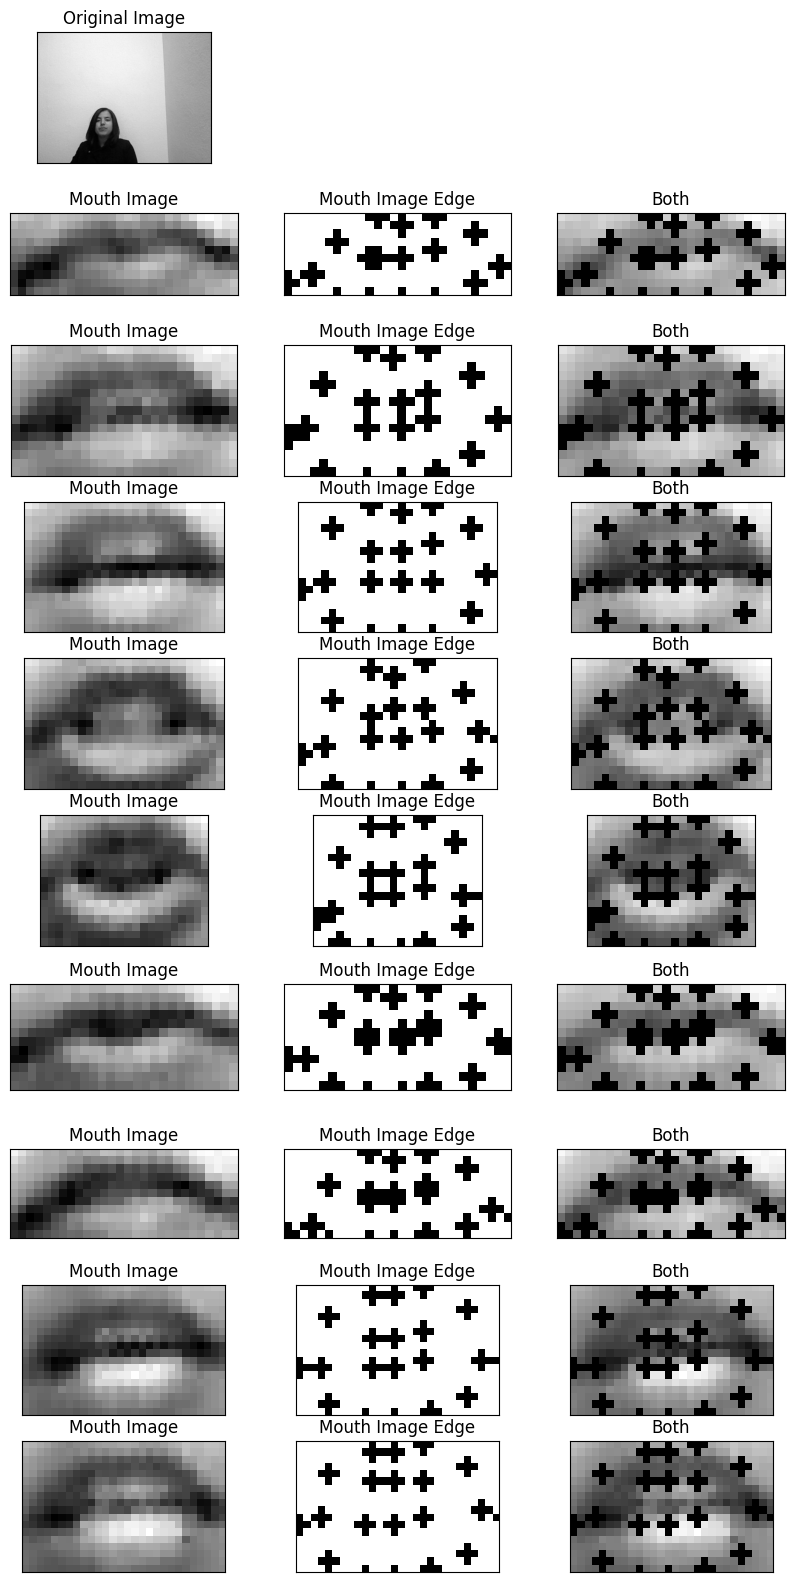

In [15]:
COLS = 3
plt.figure(figsize=(10,20))
plt.subplot(10,COLS,1)
plt.imshow(firstImg,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
for i in range(1,10):
    id = '%03d' % i
    if not id in person[firstPerson][firstSentenceId][firstSentenceId2]:
        print("%s not found!" % id)
    else:
        mouth = person[firstPerson][firstSentenceId][firstSentenceId2][id]["mouth"]
        shape = person[firstPerson][firstSentenceId][firstSentenceId2][id]["shape"]
        plt.subplot(10,COLS,COLS+1+(i-1)*COLS)
        plt.imshow(mouth,cmap = 'gray')
        plt.title('Mouth Image')
        plt.xticks([])
        plt.yticks([])
        mouthEdge = np.ones_like(mouth)
        plt.subplot(10,COLS,COLS+2+(i-1)*COLS)
        for (x, y) in shape:
            cv2.circle(mouthEdge, (x, y), 1, (0, 0, 255), -1)
        plt.imshow(mouthEdge,cmap = 'gray')
        plt.title('Mouth Image Edge')
        plt.xticks([])
        plt.yticks([])

        both = np.copy(mouth)
        plt.subplot(10,COLS,COLS+3+(i-1)*COLS)
        for (x, y) in shape:
            cv2.circle(both, (x, y), 1, (0, 0, 255), -1)
        plt.imshow(both,cmap = 'gray')
        plt.title('Both')
        plt.xticks([])
        plt.yticks([])
plt.show()

In [16]:
fileCount = 0
for p in person.keys():
    for sentenceId in person[p].keys():
        shapes = []
        for sentenceId2 in person[p][sentenceId].keys():
            for id in person[p][sentenceId][sentenceId2].keys():
                shape = person[p][sentenceId][sentenceId2][id]["shape"]
                for (x,y) in shape:
                    shapes.append((id,sentenceId2,x,y))
        df = pd.DataFrame(data = shapes,columns = ['id','sentenceId2','x','y'])
        path = "%s/phrases/%s" % (p,sentenceId)
        try:
            os.makedirs(path)
        except FileExistsError as e:
            pass
        filename = "shapes.csv"
        csvPath = "%s/%s" % (path,filename)
        print("saving %s" % csvPath)
        df.to_csv(csvPath)
        fileCount += 1
#total fileCount needs to be below 500
print("fileCount: %d" % fileCount)

saving F01/phrases/01/shapes.csv
saving F01/phrases/02/shapes.csv
saving F01/phrases/03/shapes.csv
saving F01/phrases/04/shapes.csv
saving F01/phrases/05/shapes.csv
saving F01/phrases/06/shapes.csv
saving F01/phrases/07/shapes.csv
saving F01/phrases/08/shapes.csv
saving F01/phrases/09/shapes.csv
saving F01/phrases/10/shapes.csv
saving F02/phrases/01/shapes.csv
saving F02/phrases/02/shapes.csv
saving F02/phrases/03/shapes.csv
saving F02/phrases/04/shapes.csv
saving F02/phrases/05/shapes.csv
saving F02/phrases/06/shapes.csv
saving F02/phrases/07/shapes.csv
saving F02/phrases/08/shapes.csv
saving F02/phrases/09/shapes.csv
saving F02/phrases/10/shapes.csv
saving F04/phrases/01/shapes.csv
saving F04/phrases/02/shapes.csv
saving F04/phrases/03/shapes.csv
saving F04/phrases/04/shapes.csv
saving F04/phrases/05/shapes.csv
saving F04/phrases/06/shapes.csv
saving F04/phrases/07/shapes.csv
saving F04/phrases/08/shapes.csv
saving F04/phrases/09/shapes.csv
saving F04/phrases/10/shapes.csv
saving F05